In [2]:
#Packages
import cobra
from cobra import Reaction, Metabolite, Model
from cobra.io import read_sbml_model
from cobra.flux_analysis import flux_variability_analysis

#Model input
modelOE=read_sbml_model('iJN678mod.xml')

In [3]:
#change the culture condition to be fully autotrophic as production needed
co2OE=modelOE.reactions.get_by_id("EX_co2_e")
photonOE=modelOE.reactions.get_by_id("EX_photon_e")
hco3OE=modelOE.reactions.get_by_id("EX_hco3_e")

co2OE.bounds=(-3.7,1000.0)
hco3OE.bounds= (-3.7,1000.0)
photonOE.bounds= (-100,0)

medium = modelOE.medium
medium["EX_glc__D_e"] = 0.0
medium["EX_hco3_e"] = 0.0
medium["EX_photon_e"]=54.5
modelOE.medium = medium

In [4]:
print("The genes that could be overexpressed are:")
print("sll0513, encoding: Squalene synthase" , modelOE.reactions.get_by_id("SQLS"))
print("sll1945, encoding: 1-deoxy-D-xylulose 5-phosphate synthase:" , modelOE.reactions.get_by_id("DXPS"))
print("sll1556, encoding: Isopentenyl-diphosphate D-isomerase" , modelOE.reactions.get_by_id("IPDDI"))
print("pys, encoding: Geranyltranstransferase" , modelOE.reactions.get_by_id("GRTT"))

The genes that could be overexpressed are:
sll0513, encoding: Squalene synthase SQLS: 2.0 frdp_c + h_c + nadph_c --> nadp_c + 2.0 ppi_c + sql_c
sll1945, encoding: 1-deoxy-D-xylulose 5-phosphate synthase: DXPS: g3p_c + h_c + pyr_c --> co2_c + dxyl5p_c
sll1556, encoding: Isopentenyl-diphosphate D-isomerase IPDDI: ipdp_c <=> dmpp_c
pys, encoding: Geranyltranstransferase GRTT: grdp_c + ipdp_c --> frdp_c + ppi_c


In [5]:
#change objective to squalene production
modelOE.objective = "EX_sql_e"
print("The theoretical maximum Squalene production rate is: ", modelOE.optimize().objective_value, "mmol/gdcw/h")
print("The CO2, carbon source, uptake rate is: ", -modelOE.optimize().fluxes['EX_co2_e'], "mmol/gdcw/h")
print("The biomass production under this condition is: " , modelOE.optimize().fluxes['BIOMASS_Ec_SynAuto'], "/h")

The theoretical maximum Squalene production rate is:  0.12333333333333342 mmol/gdcw/h
The CO2, carbon source, uptake rate is:  3.7 mmol/gdcw/h
The biomass production under this condition is:  0.0 /h


In [6]:
modelOE.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,3.7,1,100.00%
h2o_e,EX_h2o_e,3.083,0,0.00%
photon_e,EX_photon_e,49.33,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
o2_e,EX_o2_e,-5.242,0,0.00%
sql_e,EX_sql_e,-0.1233,0,0.00%


In [7]:
x=[]
y=[]
z=[]
k=[]
Biomass=[]
Productivity=[]
SQL=[]
optimum_value=[]
with modelOE:
        medium = modelOE.medium
        modelOE.objective = "EX_sql_e"
        optimum=modelOE.optimize().objective_value
        i=0.05
        while i<1:
            FVA=flux_variability_analysis(modelOE,modelOE.reactions.BIOMASS_Ec_SynAuto,fraction_of_optimum=i)
            Biomass.append(FVA.maximum.item())
            Productivity.append(-i*optimum*FVA.maximum.item()/modelOE.optimize().fluxes['EX_co2_e'])
            SQL.append(i*optimum)
            optimum_value.append(i)
            i+=0.05 
        x.append(Biomass)
        y.append(Productivity)
        z.append(SQL)
        k.append(optimum_value)

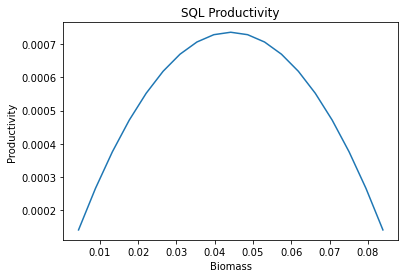

In [8]:
import matplotlib.pyplot as plt
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],y[i])
    plt.xlabel("Biomass")
    plt.ylabel("Productivity")
    plt.title('SQL Productivity') 
plt.show()

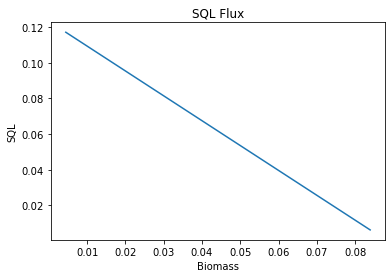

In [9]:
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],z[i])
    plt.xlabel("Biomass")
    plt.ylabel("SQL")
    plt.title('SQL Flux') 
plt.show()

In [10]:
Biomass_sorted,Productivity_sorted,SQLsorted,optimum_value_sorted = zip(*sorted(list(zip(Biomass, Productivity,SQL,optimum_value)), key=lambda item: item[1], reverse=True))
print("The highest productivity will be reached when:")
print("growth rate is ", Biomass_sorted[1], "/h,")
print("and the corresponding productivity will be", Productivity_sorted[1], "mol/mol/h")
print("The squalene production rate will be",SQLsorted[1], "mmol/gdcw/h." )
print("The optimum value set for production of SQL is",  optimum_value_sorted[1])

The highest productivity will be reached when:
growth rate is  0.04859441594166733 /h,
and the corresponding productivity will be 0.0007289162391250104 mol/mol/h
The squalene production rate will be 0.05550000000000004 mmol/gdcw/h.
The optimum value set for production of SQL is 0.44999999999999996


In [11]:
#set the bounds of SQLS
modelOE.reactions.get_by_id('SQLS').bounds = (0.06783333333333337,0.06783333333333337)
print("The optimal fluxes of the reaction corresponding to the overexpression genes are:")
print("For Squalene synthase: ", modelOE.optimize().fluxes['SQLS'])
print("For 1-deoxy-D-xylulose 5-phosphate synthase:" , modelOE.optimize().fluxes['DXPS'])
print("For Isopentenyl-diphosphate D-isomerase" , modelOE.optimize().fluxes["IPDDI"], "#reversible reaction")
print("For Geranyltranstransferase" , modelOE.optimize().fluxes["GRTT"])

The optimal fluxes of the reaction corresponding to the overexpression genes are:
For Squalene synthase:  0.06783333333333337
For 1-deoxy-D-xylulose 5-phosphate synthase: 0.4143385517945843
For Isopentenyl-diphosphate D-isomerase 0.0 #reversible reaction
For Geranyltranstransferase 0.13750203523663862


The squalene bounds are set to a fixed value at  0.06783333333333337, in order to make sure the desired biomass flux can be achieved when objective is set to suqlane production.

In [12]:
#To compare with model optimised for cell growth
model_growth=read_sbml_model('iJN678mod.xml')  
model_growth.objective = "BIOMASS_Ec_SynAuto"

In [13]:
print("Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:")
print("For Squalene synthase: the flux increased from", model_growth.optimize().fluxes['SQLS'], "to", modelOE.optimize().fluxes['SQLS'])

print("For 1-deoxy-D-xylulose 5-phosphate synthase, flux increased by:" , modelOE.optimize().fluxes['DXPS']*100/model_growth.optimize().fluxes['DXPS'], "%")

ipddiflux=flux_variability_analysis(model_growth,model_growth.reactions.get_by_id("IPDDI"),fraction_of_optimum=1)
ipddi_increase = (modelOE.optimize().fluxes["IPDDI"]-ipddiflux.minimum.item())*100/(model_growth.optimize().fluxes["IPDDI"]-ipddiflux.minimum.item())
print("For Isopentenyl-diphosphate D-isomerase , flux increased by:", ipddi_increase, "%, in the direction of favouring Isopentenyl diphosphate")
print("For Geranyltranstransferase, flux increased by:" , modelOE.optimize().fluxes["GRTT"]*100/model_growth.optimize().fluxes["GRTT"], "%")

Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:
For Squalene synthase: the flux increased from 0.0 to 0.06783333333333337
For 1-deoxy-D-xylulose 5-phosphate synthase, flux increased by: 3885.7421363707817 %
For Isopentenyl-diphosphate D-isomerase , flux increased by: 74.99004406662613 %, in the direction of favouring Isopentenyl diphosphate
For Geranyltranstransferase, flux increased by: 5156.02284510191 %
